In [1]:
from nlp_ai_utils import *
from chunks_urls import CHUNKS_URLS
from updating_values import DATA_LIMIT

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already u

In [2]:
#set this variable to true if you are using light more, or false if you are using dark mode.
JUPYTER = False
RANDOM_STATE = 42

In [3]:
TF_ENABLE_ONEDNN_OPTS = 0
URLS = CHUNKS_URLS
LIMIT = DATA_LIMIT
LARGER_DATASET_PATH = "../larger_dataset"
PREPROCESSED_CHUNKS_PATH = LARGER_DATASET_PATH + "/preprocessed_data_chunks/"
BASE_FILE_NAME = "chunk_"
FILE_FORMAT = ".csv"
ACTUAL_DATA_SHAPE = 6990280
RANDOM_STATE = 42
USE_READY_DATA = False

### 1.1 Data Sourcing and Munging

#### 1.1.1 Utility Functions

In [4]:
if not os.path.exists(LARGER_DATASET_PATH):
    os.mkdir(LARGER_DATASET_PATH)
if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
    os.mkdir(PREPROCESSED_CHUNKS_PATH)
get_chunks(URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

chunk_1 already exists.
chunk_2 already exists.
chunk_3 already exists.
chunk_4 already exists.
chunk_5 already exists.
chunk_6 already exists.


In [5]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [6]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [7]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [8]:
#check how much of the data was actually downloaded
percent_loaded = check_no_missing_data(df.shape[0],ACTUAL_DATA_SHAPE)
percent_loaded

10.000028611157207

In [9]:
df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [10]:
review_data = df[['text', 'stars']].copy()

In [11]:
review_data

,text,stars
0,"If you decide to eat here, just be aware it is...",3.0
1,I've taken a lot of spin classes over the year...,5.0
2,Family diner. Had the buffet. Eclectic assortm...,3.0
3,"Wow! Yummy, different, delicious. Our favo...",5.0
4,Cute interior and owner (?) gave us tour of up...,4.0
...,...,...
116500,I'm so thrilled to discover this wonderful Fre...,5.0
116501,We were excited and hopeful to try this restau...,3.0
116502,We like to visit Gators when we are at Treasur...,4.0
116503,It was a cool night in New Orleans and I set u...,4.0


In [12]:
review_data.reset_index(inplace = True)
review_data.drop(['index'],axis = 1,inplace = True)

In [13]:
review_data.rename(columns = {'text':'full_review_text','stars':'star_rating'}, inplace = True)

In [14]:
review_data

,full_review_text,star_rating
0,"If you decide to eat here, just be aware it is...",3.0
1,I've taken a lot of spin classes over the year...,5.0
2,Family diner. Had the buffet. Eclectic assortm...,3.0
3,"Wow! Yummy, different, delicious. Our favo...",5.0
4,Cute interior and owner (?) gave us tour of up...,4.0
...,...,...
699025,I'm so thrilled to discover this wonderful Fre...,5.0
699026,We were excited and hopeful to try this restau...,3.0
699027,We like to visit Gators when we are at Treasur...,4.0
699028,It was a cool night in New Orleans and I set u...,4.0


In [15]:
review_data.isnull().sum()

full_review_text    0
star_rating         0
dtype: int64

In [16]:
review_data.dropna(inplace = True)

In [17]:
review_data['full_review_text'].replace('', np.nan, inplace=True)
review_data.dropna(inplace = True)

In [18]:
review_data['full_review_text'] = [new_text.lstrip('0123456789.- ') for new_text in review_data['full_review_text']]
review_data['full_review_text'] = [new_text.lstrip('s') for new_text in review_data['full_review_text']]

Text(0.5, 1.0, 'Word Cloud of Unique Words')

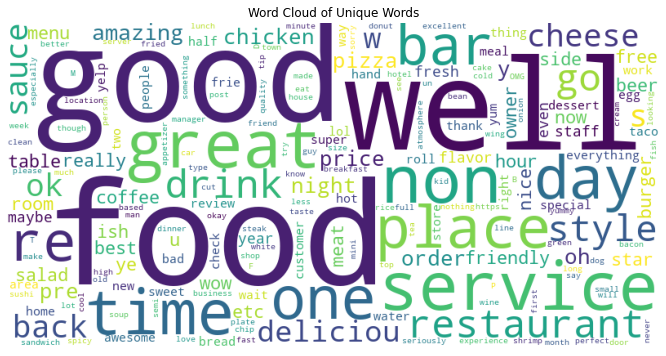

In [19]:
# Extract unique words from the text data
if USE_READY_DATA:
    if os.path.exists("../archived_files/pickle_files/unique_words.pickle"):
        unique_words = pickle.load(open("../archived_files/pickle_files/unique_words.pickle",'rb'))
    else:
        unique_words = set(' '.join(review_data['full_review_text']).split())
else:
    unique_words = set(' '.join(review_data['full_review_text']).split())

# Create a word cloud of the unique words
unique_wordcloud = WordCloud(width=800, height=400, background_color='white',random_state = RANDOM_STATE).generate(' '.join(unique_words))
plt.figure(figsize=(12, 6))
plt.imshow(unique_wordcloud)
plt.axis('off')
plt.title('Word Cloud of Unique Words')

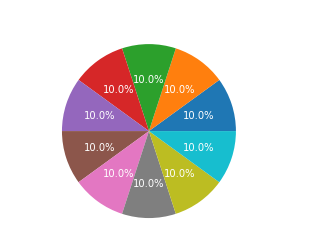

In [20]:
# count word occurrences and store them
word_counts = collections.Counter(list(unique_words))

# Get the most common words and their counts
most_common = word_counts.most_common(10)
labels = [word[0] for word in most_common]
values = [word[1] for word in most_common]

# Create the pie chart
if JUPYTER:
    color = "black"
else:
    color = "white"
plt.pie(values, labels=labels, autopct='%1.1f%%', textprops={'color': color})
plt.title('Most Common Words',color=color)
plt.show()

Text(0, 0.5, 'Word')

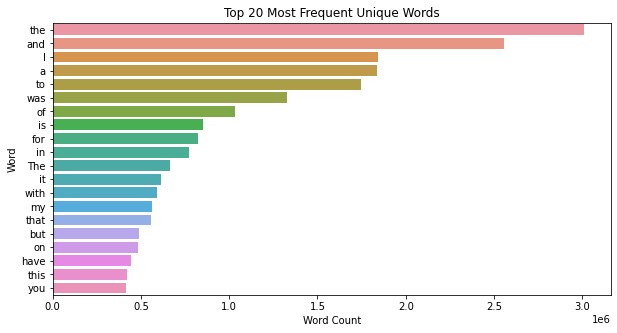

In [21]:
# Count the number of occurrences of each unique word and create a bar chart of the top 20 most frequent unique words
unique_word_count = review_data['full_review_text'].str.split(expand=True).stack().value_counts()
top_unique_words = unique_word_count.loc[unique_word_count.index.isin(unique_words)].head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_unique_words.values, y=top_unique_words.index)
plt.title('Top 20 Most Frequent Unique Words')
plt.xlabel('Word Count')
plt.ylabel('Word')

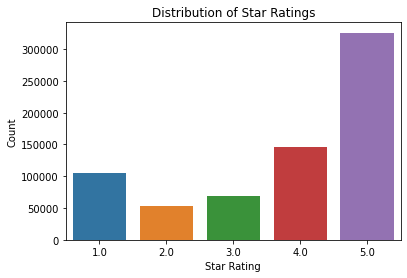

In [22]:
# Create a countplot of the star ratings using Seaborn
sns.countplot(x=review_data['star_rating'])

# Add some labels and titles
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Distribution of Star Ratings')

# Show the plot
plt.show()

In [23]:
sid = SentimentIntensityAnalyzer()
sent_polarity_words = [sid.polarity_scores(word) for word in unique_words]

In [24]:
word_sentiments = []

In [25]:
word_frequencies = {'Positive': {}, 'Negative': {}, 'Neutral': {}}

In [26]:
for i,word in enumerate(unique_words):
    if sent_polarity_words[i]['compound'] > 0:
        word_sentiments.append((word, 'Positive'))
    elif sent_polarity_words[i]['compound'] < 0:
        word_sentiments.append((word, 'Negative'))       
    else:
        word_sentiments.append((word, 'Neutral'))

In [27]:
for word, sentiment in word_sentiments:
    if word in word_frequencies[sentiment]:
        word_frequencies[sentiment][word] += 1
    else:
        word_frequencies[sentiment][word] = 1

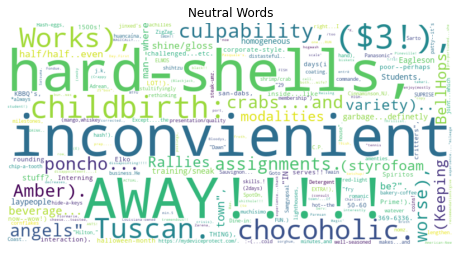

In [28]:
# Generate word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies['Positive'])

# Plot the positive word cloud
plt.figure(figsize=(8, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')
plt.show()

In [ ]:
# Generate word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies['Negative'])

# Plot the negative word cloud
plt.figure(figsize=(8, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()

In [32]:
#Visualizing the word vector space of the dataset
vectorizer = CountVectorizer()
if USE_READY_DATA:
    if os.path.exists("../archived_files/pickle_files/word2vec_model_sklearn.pickle"):
        word_embedding = pickle.load(open("../archived_files/pickle_files/word2vec_model_sklearn.pickle",'rb'))
    else:
        word_embedding = vectorizer.fit_transform(review_data['full_review_text'])
else:
    word_embedding = vectorizer.fit_transform(review_data['full_review_text'])

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=RANDOM_STATE)
svd.fit(word_embedding)

TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [36]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
embedded_tsne = tsne.fit_transform(word_embedding)

# Plot the t-SNE visualization
plt.figure(figsize=(8, 8))
plt.scatter(embedded_tsne[:, 0], embedded_tsne[:, 1])
for i, txt in enumerate(embedded_tsne):
    plt.annotate(txt, (embedded_tsne[i, 0], embedded_tsne[i, 1]))
plt.title("t-SNE Visualization of Text Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

MemoryError: Unable to allocate 905. GiB for an array with shape (699030, 173688) and data type int64